In [ ]:
#
# Script for comparing WL and FSS
# João Inácio, May 10th, 2021
#

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [11]:
# Simulation parameters

dim = "2D"
lattice = "SS"
NN = 4

L = 8
N_atm = L**2

max_E = (1 / 2) * NN * N_atm
max_M = N_atm
NE = int(1 + (max_E / 2))
NM = N_atm + 1
energies = np.linspace(- max_E, max_E, NE)
magnetizations = np.linspace(- max_M, max_M, NM)

n_run = 100

# WL 
f_final_exp_vals = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11])
f_final_vals = 1 + 10.0**(- f_final_exp_vals)
flatness = 90

# FSS
REP_exp_vals = np.array([3, 4, 5, 6])
REP_vals = 10**REP_exp_vals
skip = N_atm

q_max = (NM + 1) // 2 - 2
if NM % 2 == 0:
    q_max = NM // 2 - 3


In [12]:
# Declaration of arrays

# FSS

JDOS_all_fss = list()
for i in range(len(REP_exp_vals)):
    JDOS_all_fss.append(list())

wall_time_all_fss = np.zeros((n_run, len(REP_exp_vals)))
q_time_E_all_fss = np.zeros((n_run, len(REP_exp_vals)))

cfg_chkbrd_fss = np.zeros((n_run, len(REP_exp_vals)))
cfg_slice_fss = np.zeros((n_run, len(REP_exp_vals)))
cfg_zerozero_fss = np.zeros((n_run, len(REP_exp_vals)))

JDOS_mean_fss = list()
wall_time_mean_fss = list()
q_time_E_mean_fss = list()

#WL 

JDOS_all_wl = list()
for i in range(len(f_final_exp_vals)):
    JDOS_all_wl.append(list())

wall_time_all_wl = np.zeros((n_run, len(f_final_exp_vals)))
q_time_E_all_wl = np.zeros((n_run, len(f_final_exp_vals)))

cfg_chkbrd_wl = np.zeros((n_run, len(f_final_exp_vals)))
cfg_slice_wl = np.zeros((n_run, len(f_final_exp_vals)))
cfg_zerozero_wl = np.zeros((n_run, len(f_final_exp_vals)))

JDOS_mean_wl = list()
wall_time_mean_wl = list()
q_time_E_mean_wl = list()


In [13]:
# Read FSS data

for k, REP_exp in enumerate(REP_exp_vals):
    for run in range(1, n_run + 1):
        file_name = "".join(("./data/fss/L", str(L), "/", str(REP_exp),"/",
                             str(run), "_JDOS_FSS_Ising_", dim, "_", lattice, 
                             "_L", str(L), "_REP_1E", str(REP_exp), 
                             "_skip_", str(skip)))
        JDOS = np.loadtxt(file_name + ".txt")
        JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]

        cfg_chkbrd_fss[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice_fss[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero_fss[run - 1, k] = JDOS[energies==0, magnetizations==0]

        JDOS_all_fss[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")

            q_time_E = np.zeros(q_max)
            for i in range(0, q_max):
                line = data_file.readline().strip("\n").split(" ")
                q_time_E[i] = float(line[4])

            wall_time_all_fss[run - 1, k] = float(data_file.readline().strip("\n"))
            q_time_E_all_fss[run - 1, k] = np.sum(q_time_E)
    
    JDOS_mean_fss.append(sum(JDOS_all_fss[k]) / n_run)
    wall_time_mean_fss.append(sum(wall_time_all_fss[:, k]) / n_run)
    q_time_E_mean_fss.append(np.average(q_time_E_all_fss[:, k]))
    
    print("REP: ", REP_vals[k])
    print("Mean Wall time: {:.5f} seconds".format(wall_time_mean_fss[k]))
    print("Mean q_time / E: {:.5f} seconds".format(q_time_E_mean_fss[k]))
    print("------------------------------------")


REP:  1000
Mean Wall time: 8.20909 seconds
Mean q_time / E: 0.29929 seconds
------------------------------------
REP:  10000
Mean Wall time: 75.10649 seconds
Mean q_time / E: 2.74967 seconds
------------------------------------
REP:  100000
Mean Wall time: 714.10775 seconds
Mean q_time / E: 26.19970 seconds
------------------------------------
REP:  1000000
Mean Wall time: 6481.18560 seconds
Mean q_time / E: 238.60932 seconds
------------------------------------


In [14]:
# Read WL data

for k, f_final_exp in enumerate(f_final_exp_vals):
    for run in range(1, n_run + 1):
        file_name = "".join(("./data/wl/L", str(L), "/", str(f_final_exp),"/",
                             str(run), "_JDOS_WL_Ising_", dim, "_", lattice, 
                             "_L", str(L), "_f", str(f_final_exp), 
                             "_flatness", str(flatness)))
        JDOS = np.loadtxt(file_name + ".txt")
        JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]

        cfg_chkbrd_wl[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice_wl[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero_wl[run - 1, k] = JDOS[energies==0, magnetizations==0]

        JDOS_all_wl[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")

            #q_time_E = np.zeros(q_max)
            #for i in range(0, q_max):
            #    line = data_file.readline().strip("\n").split(" ")
            #    q_time_E[i] = float(line[4])
            
            for last_line in data_file:
                pass

            wall_time_all_wl[run - 1, k] = float(last_line)
            # q_time_E_all_wl[run - 1, k] = np.sum(q_time_E)
    
    JDOS_mean_wl.append(sum(JDOS_all_wl[k]) / n_run)
    wall_time_mean_wl.append(sum(wall_time_all_wl[:, k]) / n_run)
    # q_time_E_mean_wl.append(np.average(q_time_E_all_wl[:, k]))
    
    print("REP: ", f_final_vals[k])
    print("Mean Wall time: {:.5f} seconds".format(wall_time_mean_wl[k]))
    # print("Mean q_time / E: {:.5f} seconds".format(q_time_E_mean_wl[k]))
    print("------------------------------------")


REP:  1.001
Mean Wall time: 2.22743 seconds
------------------------------------
REP:  1.0001
Mean Wall time: 7.91740 seconds
------------------------------------
REP:  1.00001
Mean Wall time: 19.51275 seconds
------------------------------------
REP:  1.000001
Mean Wall time: 35.60364 seconds
------------------------------------
REP:  1.0000001
Mean Wall time: 57.50699 seconds
------------------------------------
REP:  1.00000001
Mean Wall time: 79.32405 seconds
------------------------------------
REP:  1.000000001
Mean Wall time: 92.39209 seconds
------------------------------------
REP:  1.0000000001
Mean Wall time: 119.61455 seconds
------------------------------------
REP:  1.00000000001
Mean Wall time: 143.91246 seconds
------------------------------------


In [15]:
# Fit normal distributions to configurations - shuffle

fit_chkbrd_fss = np.zeros((len(REP_exp_vals), 2))
fit_slice_fss = np.zeros((len(REP_exp_vals), 2))
fit_zerozero_fss = np.zeros((len(REP_exp_vals), 2))

for k in range(len(REP_exp_vals)):
    print(REP_vals[k])
    
    # Checkerboard
    
    fit_chkbrd_fss[k] = norm.fit(cfg_chkbrd_fss[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_chkbrd_fss[k, 0], fit_chkbrd_fss[k, 1]))

    # Slice
    
    fit_slice_fss[k] = norm.fit(cfg_slice_fss[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_slice_fss[k, 0], fit_slice_fss[k, 1]))
    
    # Zerozero
    
    fit_zerozero_fss[k] = norm.fit(cfg_zerozero_fss[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_zerozero_fss[k, 0], fit_zerozero_fss[k, 1]))
    
    print("------------------------------------")


1000
mean: 1.98052; var: 0.10317
mean: 15.56254; var: 2.76322
mean: 261169950000000000.00000; var: 1244670449355973.00000
------------------------------------
10000
mean: 1.99708; var: 0.03261
mean: 16.01163; var: 0.88382
mean: 261262350000000000.00000; var: 328529249078373.50000
------------------------------------
100000
mean: 2.00044; var: 0.00861
mean: 15.95116; var: 0.28368
mean: 261276140000000000.00000; var: 106567539147716.09375
------------------------------------
1000000
mean: 1.99961; var: 0.00293
mean: 15.99690; var: 0.10563
mean: 261275760000000000.00000; var: 35714176456975.73438
------------------------------------


In [16]:
# Fit normal distributions to configurations - shuffle

fit_chkbrd_wl = np.zeros((len(f_final_exp_vals), 2))
fit_slice_wl = np.zeros((len(f_final_exp_vals), 2))
fit_zerozero_wl = np.zeros((len(f_final_exp_vals), 2))

for k in range(len(f_final_exp_vals)):
    print(f_final_vals[k])
    
    # Checkerboard
    
    fit_chkbrd_wl[k] = norm.fit(cfg_chkbrd_wl[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_chkbrd_wl[k, 0], fit_chkbrd_wl[k, 1]))

    # Slice
    
    fit_slice_wl[k] = norm.fit(cfg_slice_wl[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_slice_wl[k, 0], fit_slice_wl[k, 1]))
    
    # Zerozero
    
    fit_zerozero_wl[k] = norm.fit(cfg_zerozero_wl[:, k])
    print("mean: {:.5f}; var: {:.5f}".format(fit_zerozero_wl[k, 0], fit_zerozero_wl[k, 1]))
    
    print("------------------------------------")


1.001
mean: 1.80734; var: 0.55606
mean: 13.86252; var: 5.12769
mean: 263547490000000000.00000; var: 8835729764422405.00000
------------------------------------
1.0001
mean: 1.95656; var: 0.15521
mean: 15.71203; var: 1.46546
mean: 261414760000000000.00000; var: 2325436166055735.50000
------------------------------------
1.00001
mean: 1.98748; var: 0.06244
mean: 15.99475; var: 0.65746
mean: 261103020000000000.00000; var: 961697249450158.50000
------------------------------------
1.000001
mean: 2.00085; var: 0.03997
mean: 15.98506; var: 0.33679
mean: 261323670000000000.00000; var: 554782625088421.43750
------------------------------------
1.0000001
mean: 1.98310; var: 0.03889
mean: 16.01146; var: 0.35737
mean: 261340050000000000.00000; var: 519623216860062.87500
------------------------------------
1.00000001
mean: 1.99211; var: 0.03538
mean: 16.02393; var: 0.31463
mean: 261241890000000000.00000; var: 524760248018082.93750
------------------------------------
1.000000001
mean: 1.99445; va

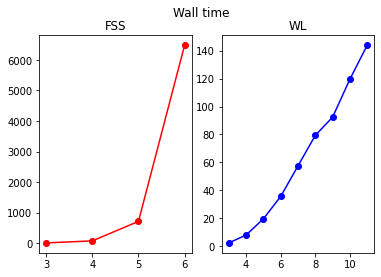

In [17]:
# Wall time comparison

fig = plt.figure(1)
fig.suptitle("Wall time")

plt.subplot(121)
plt.plot(REP_exp_vals, wall_time_mean_fss, marker='o', color='r')
plt.title("FSS")

plt.subplot(122)
plt.plot(f_final_exp_vals, wall_time_mean_wl, marker='o', color='b')
plt.title("WL")

plt.show()


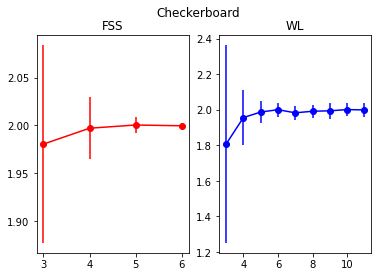

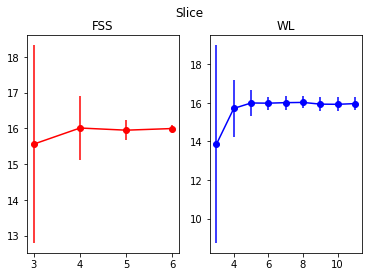

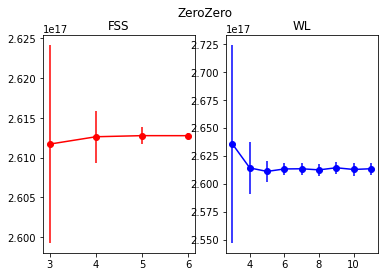

In [18]:
# Plot mean and var for the fitted distribuitions

# Checkerboard

fig = plt.figure(1)
fig.suptitle("Checkerboard")

plt.subplot(121)
plt.errorbar(REP_exp_vals, fit_chkbrd_fss[:, 0], fit_chkbrd_fss[:, 1], marker='o', color='r')
plt.title("FSS")

plt.subplot(122)
plt.errorbar(f_final_exp_vals, fit_chkbrd_wl[:, 0], fit_chkbrd_wl[:, 1], marker='o', color='b')
plt.title("WL")

# Slice

fig = plt.figure(2)
fig.suptitle("Slice")

plt.subplot(121)
plt.errorbar(REP_exp_vals, fit_slice_fss[:, 0], fit_slice_fss[:, 1], marker='o', color='r')
plt.title("FSS")

plt.subplot(122)
plt.errorbar(f_final_exp_vals, fit_slice_wl[:, 0], fit_slice_wl[:, 1], marker='o', color='b')
plt.title("WL")

# Zerozero

fig = plt.figure(3)
fig.suptitle("ZeroZero")

plt.subplot(121)
plt.errorbar(REP_exp_vals, fit_zerozero_fss[:, 0], fit_zerozero_fss[:, 1], marker='o', color='r')
plt.title("FSS")

plt.subplot(122)
plt.errorbar(f_final_exp_vals, fit_zerozero_wl[:, 0], fit_zerozero_wl[:, 1], marker='o', color='b')
plt.title("WL")

plt.show()


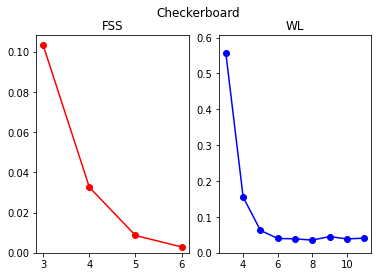

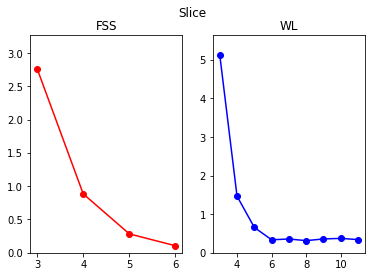

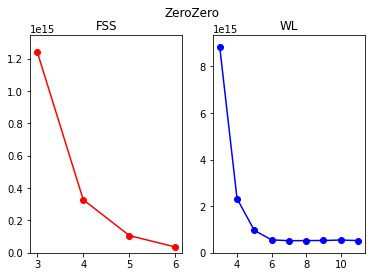

In [22]:
# Variance for both methods

# Checkerboard

fig = plt.figure(1)
fig.suptitle("Checkerboard")

plt.subplot(121)
plt.plot(REP_exp_vals, fit_chkbrd_fss[:, 1], marker='o', color='r')
plt.ylim([0, np.max(fit_chkbrd_fss[:, 1])+0.005])
plt.title("FSS")

plt.subplot(122)
plt.plot(f_final_exp_vals, fit_chkbrd_wl[:, 1], marker='o', color='b')
plt.ylim([0, np.max(fit_chkbrd_wl[:, 1])+0.05])
plt.title("WL")

# Slice

fig = plt.figure(2)
fig.suptitle("Slice")

plt.subplot(121)
plt.plot(REP_exp_vals, fit_slice_fss[:, 1], marker='o', color='r')
plt.ylim([0, np.max(fit_slice_fss[:, 1])+0.5])
plt.title("FSS")

plt.subplot(122)
plt.plot(f_final_exp_vals, fit_slice_wl[:, 1], marker='o', color='b')
plt.ylim([0, np.max(fit_slice_wl[:, 1])+0.5])
plt.title("WL")

# Zerozero

fig = plt.figure(3)
fig.suptitle("ZeroZero")

plt.subplot(121)
plt.plot(REP_exp_vals, fit_zerozero_fss[:, 1], marker='o', color='r')
plt.ylim([0, np.max(fit_zerozero_fss[:, 1])+1e14])
plt.title("FSS")

plt.subplot(122)
plt.plot(f_final_exp_vals, fit_zerozero_wl[:, 1], marker='o', color='b')
plt.ylim([0, np.max(fit_zerozero_wl[:, 1])+5e14])
plt.title("WL")


plt.show()
